In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Any, Union

CSV_DATA = Path().cwd().parent.parent / "data/2_loaded"

In [2]:
# Load the summary  for reference later
df_summary = pd.read_csv(CSV_DATA/'summary/ride_summary_good.csv')
df_summary['start_date'] = pd.to_datetime(df_summary['start_date'])
df_summary['year'] = df_summary['start_date'].dt.year
df_summary['month'] = df_summary['start_date'].dt.month
df_summary['month_name'] = df_summary['start_date'].dt.month_name()
df_summary['start_time'] = pd.to_timedelta(df_summary['start_time'])
df_summary['end_time'] = pd.to_timedelta(df_summary['end_time'])

## Handle categorical variables
month_order = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
df_summary['month_name'] = pd.Categorical(df_summary['month_name'] , categories=month_order.keys(), ordered=True)

In [3]:
df_summary24 = df_summary.loc[df_summary['year']==2024].reset_index(drop=True)
df_summary24.head(10)

,ride_id,start_date,start_time,end_time,biker_weight_lbs,bike_weight,bag_weight,avg_speed,avg_cruising_speed,total_ride_time_sec,total_moving_time_sec,total_distance_mi,total_ascent_ft,total_descent_ft,avg_heart_rate,avg_power,avg_cadence,avg_ambient_temp_F,best_power_4s,best_power_5s,best_power_10s,best_power_20s,best_power_30s,best_power_1m,best_power_2m,best_power_3m,best_power_4m,best_power_5m,best_power_6m,best_power_10m,best_power_20m,best_power_30m,best_power_40m,best_power_1h,best_power_2h,year,month,month_name
0,0x65bfd8be,2024-02-04,0 days 18:34:38,0 days 19:28:53,220,25,0,9.527357,12.342948,3256.0,2351.0,8.458264,187.6732,279.5412,115.555538,65.028793,NaN,78.103880,310.255589,308.123565,291.439272,255.712946,235.955278,195.692452,147.293070,137.515048,132.528701,133.569889,131.174928,123.819794,100.665176,85.945107,80.512619,NaN,NaN,2024,2,February
1,0x65cbcb8d,2024-02-13,0 days 20:05:33,0 days 20:51:03,220,25,0,10.363345,13.050481,2731.0,1756.0,6.834804,242.7940,242.7940,NaN,81.952892,NaN,NaN,354.250825,351.659801,324.016790,269.726666,242.969958,209.420901,184.329614,149.468923,134.825479,127.061890,123.451692,117.591013,106.189645,94.502171,NaN,NaN,NaN,2024,2,February
2,0x661c5dfa,2024-04-14,0 days 22:51:38,0 days 23:14:49,220,25,0,5.725683,10.515063,1392.0,675.0,2.148722,225.7328,219.1708,117.258697,64.042326,NaN,85.496373,621.616926,613.770179,557.898004,423.739887,340.487773,271.976950,185.269449,139.440852,138.451007,137.619784,124.446161,96.657370,70.645655,NaN,NaN,NaN,NaN,2024,4,April
3,0x661ff649,2024-04-17,0 days 16:18:17,0 days 18:26:22,220,25,0,7.142026,12.506619,7686.0,3072.0,12.225232,1375.3952,1339.3042,144.480039,87.020642,NaN,83.411587,1170.473521,1158.334870,1073.148701,825.049190,596.478742,414.423510,361.223633,277.179928,217.968068,205.941190,201.338120,167.342438,153.785987,132.428478,113.835832,107.662383,NaN,2024,4,April
4,0x663a3144,2024-05-07,0 days 13:48:52,0 days 16:32:57,220,25,0,12.223941,14.645619,5280246.0,8762.0,35.946595,562.3634,547.9270,136.719535,99.213123,NaN,83.772700,342.918232,340.783854,318.812139,264.332044,235.599506,190.750307,175.318029,170.242772,163.004630,157.527646,154.944776,142.513938,130.809078,128.724365,124.516872,117.253850,105.76314,2024,5,May
5,0x663c00a2,2024-05-08,0 days 22:45:54,0 days 23:55:29,220,25,0,8.652486,10.287778,4176.0,2246.0,7.471199,657.1843,656.5281,NaN,89.754090,NaN,NaN,531.334783,525.811247,494.637429,426.247806,381.974504,328.935914,285.543303,245.595262,231.205603,245.508425,234.585140,171.447654,127.023064,109.203417,101.833759,NaN,NaN,2024,5,May
6,0x66452ebc,2024-05-15,0 days 21:53:00,0 days 23:24:13,220,25,0,12.071955,13.298839,5474.0,3455.0,13.192520,300.2115,299.2272,NaN,91.809308,NaN,NaN,538.578938,535.168991,513.367014,455.593648,406.180150,307.453199,208.742520,174.692446,148.241910,139.734390,139.086289,134.153966,108.388087,100.131336,95.667646,94.087060,NaN,2024,5,May
7,0x6647e479,2024-05-17,0 days 23:12:57,0 days 00:55:30,220,25,0,14.820830,15.589168,6154.0,3493.0,15.286096,262.1519,262.1519,NaN,130.205369,NaN,NaN,483.336974,474.137319,417.844343,322.169952,286.297521,267.139890,240.650760,238.074818,229.369084,209.055920,208.271654,200.659436,184.131321,163.012482,144.401665,131.524576,NaN,2024,5,May
8,0x6653585c,2024-05-26,0 days 15:42:20,0 days 16:10:25,220,25,0,10.272558,11.997267,1686.0,1038.0,3.707279,346.1455,345.4893,NaN,122.349943,NaN,NaN,601.359216,600.134853,591.879950,569.112684,552.564718,475.708726,368.238988,291.597926,243.445718,228.543115,220.277087,168.737013,132.389125,NaN,NaN,NaN,NaN,2024,5,May
9,0x6657ad77,2024-05-29,0 days 22:34:31,0 days 00:12:31,220,25,0,10.606017,12.403217,5881.0,2356.0,8.791491,683.1042,682.7761,NaN,115.805535,NaN,NaN,744.631330,734.497080,679.351453,541.024407,437.271497,412.277786,358.298343,315.488671,303.259288,263.828504,261.952850,230.578543,157.927507,136.891962,125.807889,NaN,NaN,2024,5,May


In [4]:
from pathlib import Path
import re

class RidePowerCurve:
    def __init__(self, df_summary:pd.DataFrame, ride_id:str, ride_data_path:str):
        self.df_summary = df_summary
        self.ride_id = ride_id
        self.ride_data_path = ride_data_path

        # Read in the ride data
        ride_file_name = Path(ride_data_path) / f"{ride_id}.csv"
        if not ride_file_name.exists(): raise FileNotFoundError(f'The file "{ride_file_name}" does not exist')
        self.df_ride = pd.read_csv(ride_file_name)
        self.df_ride['time'] = pd.to_datetime(self.df_ride['time'])

        # Extract the Route from the ride
        cols_of_interest = ['time','segment_id','delta_dist_ft','delta_ele_ft','filt_grade_saturated','heading']
        self.df_route = self.df_ride.copy().loc[self.df_ride['delta_dist_ft']!=0.0, cols_of_interest]

    @property
    def power_params(self):
        power_params = {
                  'area': 0.4635862, # m^2
                  'mu_rr': 0.005, # coefficient of rolling friction
                  'c_drag': 0.95, # coefficient of drag
                  'rho_air': 1.2, # kg/m^3 air density
                  'eta_dt': 0.96, # efficiency of drive train
                  'gravity': 9.8 # m/s^2
                 }
        return power_params

    def generate_hypothetical_route_power_curve(self, target_avg_speed_mph:float=None, 
                                                target_completion_time_minutes:float=None, verbose:bool=True, 
                                                target_ride_weight_lbs:float=None) -> pd.DataFrame:
        """
        This method takes in a hypothetical scenario (i.e. a target avg. speed or a target completion time) and generates
        the expected power curve for the route completed under those conditions
        """
        # Check for errors where none or both are set
        if (target_avg_speed_mph is None) and (target_completion_time_minutes is None):
            raise ValueError('Either "target_avg_speed_mph" or "target_completion_time_minutes" must be set. NONE SET')
        if (target_avg_speed_mph is not None) and (target_completion_time_minutes is not None):
            raise ValueError('Either "target_avg_speed_mph" or "target_completion_time_minutes" must be set. BUT NOT BOTH')
        
        feet_to_miles = 1.0 / 5280.0
        route_dist_mi = self.df_route['delta_dist_ft'].sum() * feet_to_miles

        # Target a constant, average speed
        if (target_avg_speed_mph is not None):
            self.df_route['speed'] = target_avg_speed_mph
            if verbose:
                print(f'The route is "{route_dist_mi}" miles.'+\
                      f' For target average speed of "{target_avg_speed_mph}" MPH, the route should take {route_dist_mi/target_avg_speed_mph} hours')
        # Target a fixed completion time
        if (target_completion_time_minutes is not None):
            target_completion_time_hr = target_completion_time_minutes / 60.0
            const_speed = route_dist_mi / target_completion_time_hr
            self.df_route['speed'] = const_speed
            if verbose:
                print(f'The route is "{route_dist_mi}" miles.'+\
                      f' For it to be completed in "{target_completion_time_hr}" hours, the average speed must be {const_speed} MPH')
        
        if target_ride_weight_lbs is None:
            # If no target weight is specified, use the actual weight from the ride that occurred
            target_ride_weight_lbs = self.df_summary.loc[self.df_summary['ride_id']==self.ride_id,
                                                          [col for col in self.df_summary.columns if 'weight' in col]].values.sum()
            if verbose: print(f'Target total ride weight: {target_ride_weight_lbs} lbs')
        # 1. Compute instantaneous power
        self.df_route = self._get_instantaneous_power(self.df_route.copy(), self.power_params, target_ride_weight_lbs)
        # 2. Get the power curve for this proposed route
        self.df_route_pwr = self._get_route_power_curve()
        # 3. Get the power curve of the actual ride
        self.df_ride_pwr = self._get_ride_power_curve()
        # 4. Concat the comparison dataframe
        df_compare = pd.concat([self.df_ride_pwr, self.df_route_pwr], ignore_index=True)
        return df_compare

    ###########################################################################################################
    # Power Curve Calculations -- Helper Methods
    ###########################################################################################################
    @staticmethod
    def _get_instantaneous_power(df:pd.DataFrame, power_params:dict, total_weight:float,
                                speed_column:str='speed', grade_column:str='filt_grade_saturated'):
        df = df.copy()
        cols_to_drop_later = ['grade_radians','speed_MpS','F_grav','F_fric','F_drag', 'F_sum', 
                            'total_speed']
        params = power_params
        pounds_to_kilograms = 0.453592
        total_mass = pounds_to_kilograms * total_weight

        # Convert the terrain slope into radians
        df['grade_radians'] = np.arctan(df[grade_column]/100)
        
        # Convert the speed units into meters per second
        mph2MpS = 0.44704 # 1 MPH = 0.44704 m/s
        df['speed_MpS'] = mph2MpS * df[speed_column]
        
        # Get the total speed component with wind (placeholder)
        df['total_speed'] = df['speed_MpS']
        
        # Calculate the individual forces
        df['F_grav'] = total_mass*params['gravity'] * np.sin(df['grade_radians'])
        df['F_fric'] = params['mu_rr']*total_mass*params['gravity'] * np.cos(df['grade_radians'])
        full_coefficient = 0.5 * params['rho_air'] * params['area'] * params['c_drag']
        df['F_drag'] = (full_coefficient) * np.power(df['total_speed'], 2) # k(v)^2
        
        # Sum the forces
        df['F_sum'] = df['F_drag'] + df['F_grav'] + df['F_fric']
        
        # Calculate the non-negative power delivered by the ride (set Power=0 for F_sum <0)
        df['inst_power'] = (1.0/params['eta_dt']) * df['F_sum'] * df['speed_MpS'] 
        df.loc[df['inst_power']<0,'inst_power'] = 0 # coasting when sum of forces is negative (no input power)

        df.drop(columns=cols_to_drop_later, inplace=True)
        
        return df
    
    @staticmethod
    def _calculate_power_curve(df: pd.DataFrame) -> dict:
        # Create a set of rolling windows to calculate a MAX over avg(inst_powers[within_window])
        rolling_windows = [4, 5, 10, 20, 30, 60, # seconds
                            2*60, 3*60, 4*60, 5*60, 6*60, 10*60, 20*60, 30*60, 40*60, # minutes
                            60*60, 2*60*60] # hours
        rwindow_labels = ['4s', '5s', '10s', '20s', '30s', '1m', # seconds
                            '2m', '3m', '4m', '5m', '6m', '10m', '20m', '30m', '40m', # minutes
                            '1h', '2h'] # hours
        label_map = {seconds:label for seconds,label in zip(rolling_windows,rwindow_labels)}

        # Initialize a list to store the peak powers per window
        window_peak_powers = []

        for rwindow in rolling_windows:
            # We should not calculate the peak power for a window that is longer than this value since it is ill defined
            rolling_avg_inst_power = df[['inst_power']].rolling(rwindow, min_periods=rwindow).mean().dropna()
            if rolling_avg_inst_power.shape[0]==0: # all values were np.nan, hence the window is too large for the ride data
                peak_power = np.nan
            else:
                peak_power = max(rolling_avg_inst_power.values)[0]
            window_peak_powers.append({'time_window':label_map[rwindow], 'window_length_seconds':rwindow, 'peak_avg_power':peak_power})
        
        # Create and output dictionary that summarizes the best power efforts by duration for this ride
        df_pwr = pd.DataFrame(window_peak_powers)
        output_summary = dict()
        for _, row in df_pwr[['time_window','peak_avg_power']].iterrows():
            output_summary[f'best_power_{row["time_window"]}'] = row['peak_avg_power']
        return output_summary
    
    def _get_route_power_curve(self) -> pd.DataFrame:
        route_power_curve = self._calculate_power_curve(self.df_route)

        # For each ride, plot its power curve
        power_column_mapping: dict = self.power_column_mapping()
        data = [{'duration':power_column_mapping[col]['duration'], 
                 'duration_label':power_column_mapping[col]['label'], 
                 'best_power':route_power_curve[col]} for col in self.power_cols]
        df_route_pwr = pd.DataFrame(data)
        df_route_pwr['duration_label'] = pd.Categorical(df_route_pwr['duration_label'], 
                                                        categories=[x.replace('best_power_','') for x in self.power_cols], ordered=True)
        df_route_pwr['ride_id']='route'
        df_route_pwr['year']=np.nan
        df_route_pwr['month']=np.nan
        df_route_pwr['month_name']=None
        df_route_pwr = df_route_pwr[['ride_id','year','month','month_name','duration','duration_label','best_power']]

        return df_route_pwr
    
    def _get_ride_power_curve(self) -> pd.DataFrame:
        # Subset the df_summary columns and filter for the relevant ride_ids
        cols_of_interest = ['ride_id', 'start_date','year','month','month_name', 'total_distance_mi','total_ascent_ft','avg_power']
        cols_of_interest += self.power_cols
        df_ride_summary = df_summary.copy().loc[df_summary['ride_id']==self.ride_id, cols_of_interest]

        # For each ride, plot its power curve
        power_column_mapping: dict = self.power_column_mapping()
        df_powers = []
        for _, row in df_ride_summary.iterrows(): # should only be 1 row # TODO: clean this up ...
            data = [{'duration':power_column_mapping[col]['duration'], 
                     'duration_label':power_column_mapping[col]['label'], 
                     'best_power':row[col]} for col in self.power_cols]
            df_pwr = pd.DataFrame(data)
            df_pwr['duration_label'] = pd.Categorical(df_pwr['duration_label'], 
                                                      categories=[x.replace('best_power_','') for x in self.power_cols], ordered=True)
            df_pwr['ride_id']=row['ride_id']
            df_pwr['year']=row['year']
            df_pwr['month']=row['month']
            df_pwr['month_name']=row['month_name']
            df_pwr = df_pwr[['ride_id','year','month','month_name','duration','duration_label','best_power']]
            df_powers.append(df_pwr)

        return pd.concat(df_powers, ignore_index=True)

    ###########################################################################################################
    # Formatting Helper Methods
    ###########################################################################################################
    @property
    def power_cols(self) -> list[str]:
        power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h', 'best_power_2h']
        return power_cols
    
    @staticmethod
    def power_column_mapping() -> dict:
        power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h', 'best_power_2h']
        # Create a mapping from power column names back to axis labels and values
        pattern = r'best_power_([\d]+)([smh])'
        seconds_map = {'s':1, 'm':60, 'h':60*60}
        power_col_map = dict()
        for col in power_cols:
            matched = re.match(pattern, col)
            if matched is not None:
                value, unit = matched.groups()
                power_col_map[col] = {'label':value+unit,'duration':int(value)*seconds_map[unit]}
        return power_col_map

# Comparing Route to Ride Curves

In [5]:
RIDE_1 = '0x663a3144'
RIDE_2 = '0x6653585c'
RIDE_3 = '0x6647e479'
rpc = RidePowerCurve(df_summary=df_summary24, ride_id=RIDE_1, ride_data_path=CSV_DATA)
df_compare_ride1 = rpc.generate_hypothetical_route_power_curve(target_avg_speed_mph=15)

rpc = RidePowerCurve(df_summary=df_summary24, ride_id=RIDE_2, ride_data_path=CSV_DATA)
df_compare_ride2 = rpc.generate_hypothetical_route_power_curve(target_avg_speed_mph=15)

rpc = RidePowerCurve(df_summary=df_summary24, ride_id=RIDE_3, ride_data_path=CSV_DATA)
df_compare_ride3 = rpc.generate_hypothetical_route_power_curve(target_avg_speed_mph=15)

The route is "35.946595173075714" miles. For target average speed of "15" MPH, the route should take 2.3964396782050477 hours
Target total ride weight: 245 lbs
The route is "3.7072788754501125" miles. For target average speed of "15" MPH, the route should take 0.2471519250300075 hours
Target total ride weight: 245 lbs
The route is "15.286096338048191" miles. For target average speed of "15" MPH, the route should take 1.0190730892032127 hours
Target total ride weight: 245 lbs


# Plotting Ride vs. Intended Route Power Curves

In [6]:
def get_top_cyclists_power_curve() -> pd.DataFrame:
    power_col_map = RidePowerCurve.power_column_mapping()
    # top 1% of cyclists, ref: https://www.cyclinganalytics.com/blog/2018/06/how-does-your-cycling-power-output-compare
    top_cyclist_powers = {'best_power_4s':1650, 'best_power_5s':1500,'best_power_10s':1375, 'best_power_20s':1200, 'best_power_30s':1000, 'best_power_1m':775,
                        'best_power_2m':600, 'best_power_3m':560, 'best_power_4m':535, 'best_power_5m':510,
                        'best_power_6m':500, 'best_power_10m':490, 'best_power_20m':460, 'best_power_30m':420,
                        'best_power_40m':375, 'best_power_1h':360}
    data = [{'duration':power_col_map[col]['duration'], 'best_power':top_cyclist_powers[col]} for col in top_cyclist_powers.keys()]
    df_pwr_top = pd.DataFrame(data)
    return df_pwr_top

In [7]:
def plot_summary_power_curves(df_pwrs:pd.DataFrame, figsize:tuple=(12,4), color_by:str='ride_id', alpha:float=0.5, ylims:list[float]=None,
                              logscale_base:int=10, title:str='Best Ride Efforts Power Curve', show_best_cyclist_curve:bool=True,
                              show_ride_id_labels:bool=False):
    ########################################################################
    # Create the Figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    # For each ride, plot its power curve
    plot_kwargs = dict(data=df_pwrs, x='duration', y='best_power', ax=ax, alpha=alpha,legend=False, hue=color_by)
    if color_by!='ride_id':
        plot_kwargs['legend']=True
        plot_kwargs['palette']='tab10'
    else:
        if show_ride_id_labels:
            plot_kwargs['legend']=True
    _ = sns.lineplot(**plot_kwargs)
    plot_kwargs['legend']=False # do not record dots in the legend
    _ = sns.scatterplot(**plot_kwargs)
    

    if show_best_cyclist_curve:
        df_pwr_top = get_top_cyclists_power_curve()
        _ = ax.plot(df_pwr_top['duration'],df_pwr_top['best_power'], alpha=0.8, c='red', linestyle='--')
        _ = ax.scatter(df_pwr_top['duration'],df_pwr_top['best_power'],label='Top 99% Cyclist', alpha=0.8, marker='d', c='red', linewidths=2)
        _ = plt.legend(loc='best')
    

    ########################################################################
    # Set the axes up for plotting
    def forward(x):
        return np.log10(x) / np.log10(logscale_base)

    def inverse(x):
        return logscale_base**x
    
    if logscale_base==10:
        _ = ax.set_xscale('log')
    else:
        _ = ax.set_xscale('function', functions=(forward,inverse))

    power_col_map = RidePowerCurve.power_column_mapping() 
    _ = plt.xticks(ticks=[col['duration'] for col in power_col_map.values()], 
                   labels=[col['label'] for col in power_col_map.values()], rotation=45)
    _ = plt.grid()
    _ = ax.set_axisbelow(True)
    _ = plt.xlabel('Effort Time Duration', fontsize=14)
    _ = plt.ylabel('Maximum Effort Power (W)', fontsize=14)
    _ = plt.title(title, fontsize=18)
    _ = plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left')
    _ = plt.tight_layout()
    if ylims is not None:
        _ = plt.ylim(ylims)

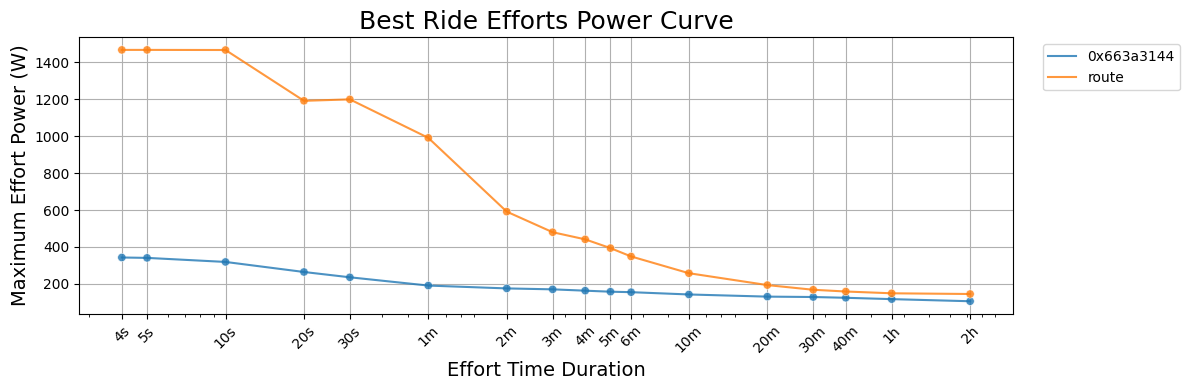

In [8]:
plot_summary_power_curves(df_compare_ride1, show_best_cyclist_curve=False, show_ride_id_labels=True, alpha=0.8)

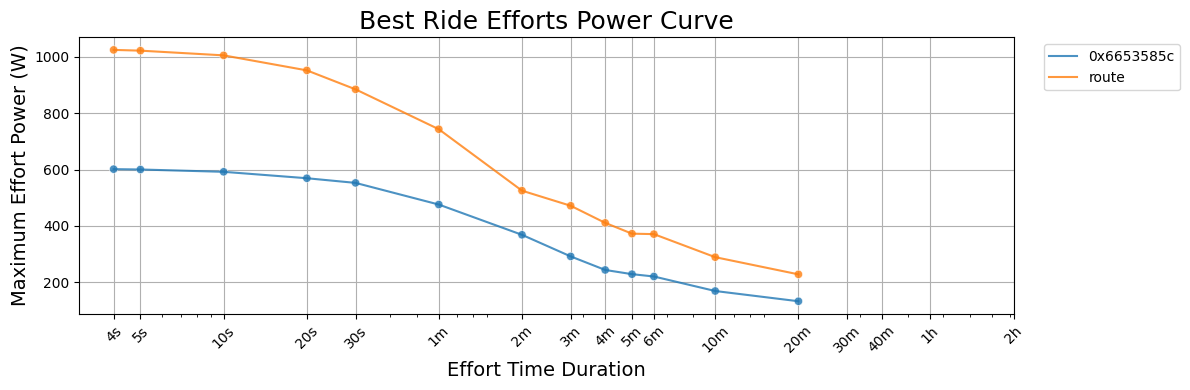

In [9]:
plot_summary_power_curves(df_compare_ride2, show_best_cyclist_curve=False, show_ride_id_labels=True, alpha=0.8)

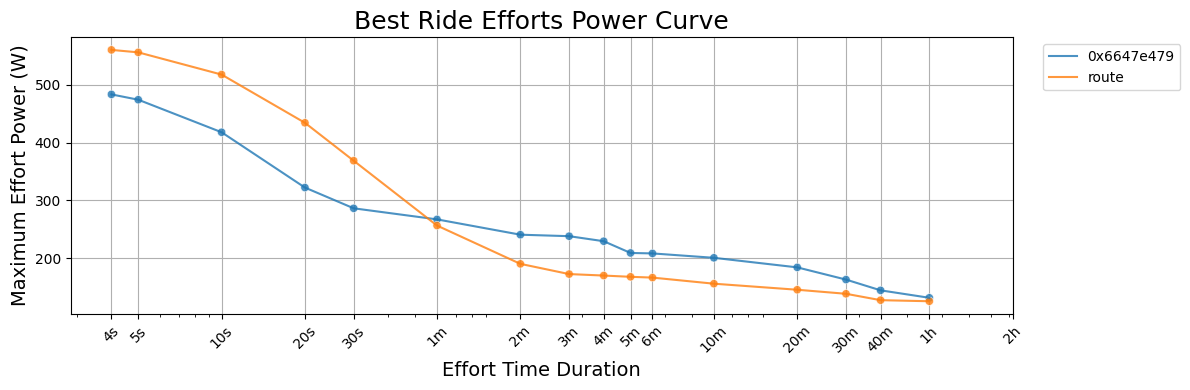

In [10]:
plot_summary_power_curves(df_compare_ride3, show_best_cyclist_curve=False, show_ride_id_labels=True, alpha=0.8)